# Credit Card Fraud Detection Analysis

## Dataset Overview
This dataset contains transactions made by credit cards in September 2013 by European cardholders. The dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, with the positive class (frauds) accounting for 0.172% of all transactions.

**Features:**
- **V1-V28**: Principal components obtained with PCA (anonymized features)
- **Time**: Seconds elapsed between each transaction and the first transaction
- **Amount**: Transaction amount
- **Class**: Response variable (1 = fraud, 0 = normal)

**Note:** Given the class imbalance, we'll use PR-AUC as the primary evaluation metric.


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                            f1_score, roc_auc_score, average_precision_score,
                            confusion_matrix, classification_report, 
                            precision_recall_curve, roc_curve)
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Set random seed for reproducibility
np.random.seed(42)


## 1. Data Overview


In [ ]:
# Load the dataset
df = pd.read_csv('creditcard.csv')
print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.shape[1]}")
df.head()


Dataset shape: (284807, 31)
Columns: 31


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
# Class distribution
class_counts = df['Class'].value_counts()
class_percentages = df['Class'].value_counts(normalize=True) * 100
print(f"Normal (0): {class_counts[0]:,} ({class_percentages[0]:.3f}%)")
print(f"Fraud (1): {class_counts[1]:,} ({class_percentages[1]:.3f}%)")
print(f"Class Imbalance Ratio: {class_counts[0]/class_counts[1]:.2f}:1")


Normal (0): 284,315 (99.827%)
Fraud (1): 492 (0.173%)
Class Imbalance Ratio: 577.88:1


In [ ]:
# Data quality check
print(f"Missing values: {df.isnull().sum().sum()}")
print(f"All features are numerical: {all(df.dtypes != 'object')}")


Missing values: 0
All features are numerical: True


## 2. Exploratory Data Analysis (EDA)


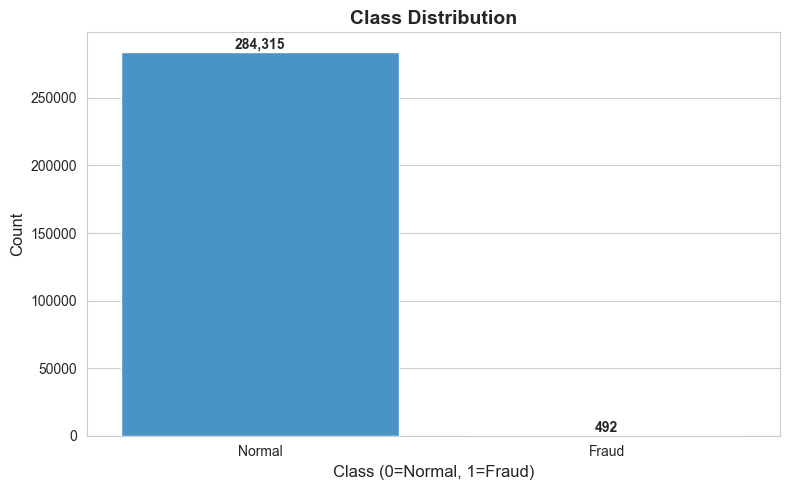

In [ ]:
# Class distribution visualization
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='Class', palette=['#3498db', '#e74c3c'])
plt.title('Class Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Class (0=Normal, 1=Fraud)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks([0, 1], ['Normal', 'Fraud'])
for i, v in enumerate(class_counts.values):
    plt.text(i, v, f'{v:,}', ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.show()


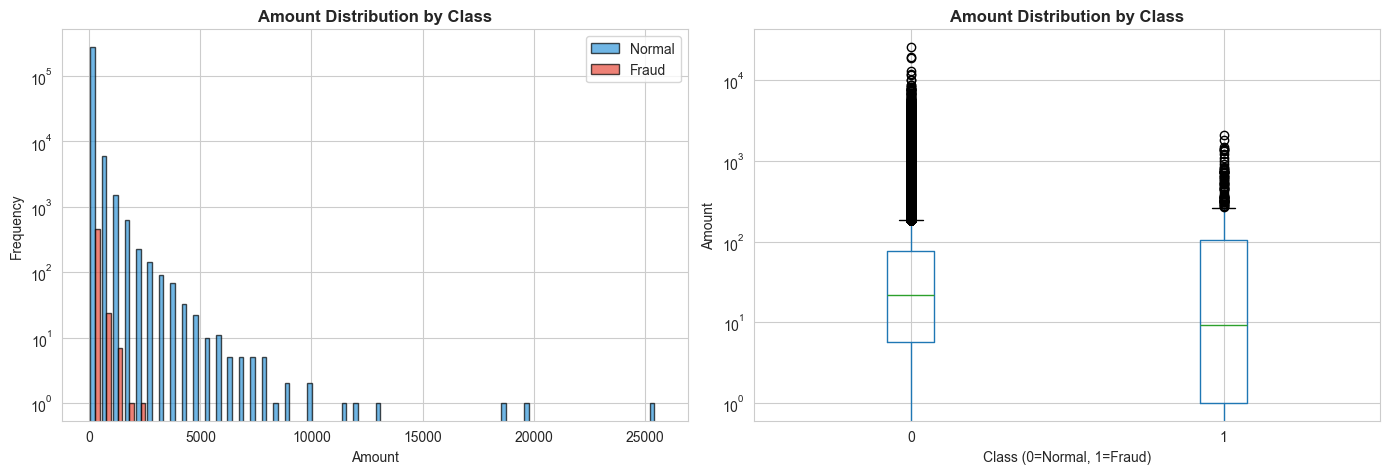

In [ ]:
# Amount distribution by class
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fraud_amounts = df[df['Class'] == 1]['Amount']
normal_amounts = df[df['Class'] == 0]['Amount']
axes[0].hist([normal_amounts, fraud_amounts], bins=50, label=['Normal', 'Fraud'],
             color=['#3498db', '#e74c3c'], alpha=0.7, edgecolor='black')
axes[0].set_title('Amount Distribution by Class', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Amount', fontsize=10)
axes[0].set_ylabel('Frequency', fontsize=10)
axes[0].legend()
axes[0].set_yscale('log')

# Box plot
df.boxplot(column='Amount', by='Class', ax=axes[1])
axes[1].set_title('Amount Distribution by Class', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Class (0=Normal, 1=Fraud)', fontsize=10)
axes[1].set_ylabel('Amount', fontsize=10)
axes[1].set_yscale('log')
plt.suptitle('')
plt.tight_layout()
plt.show()


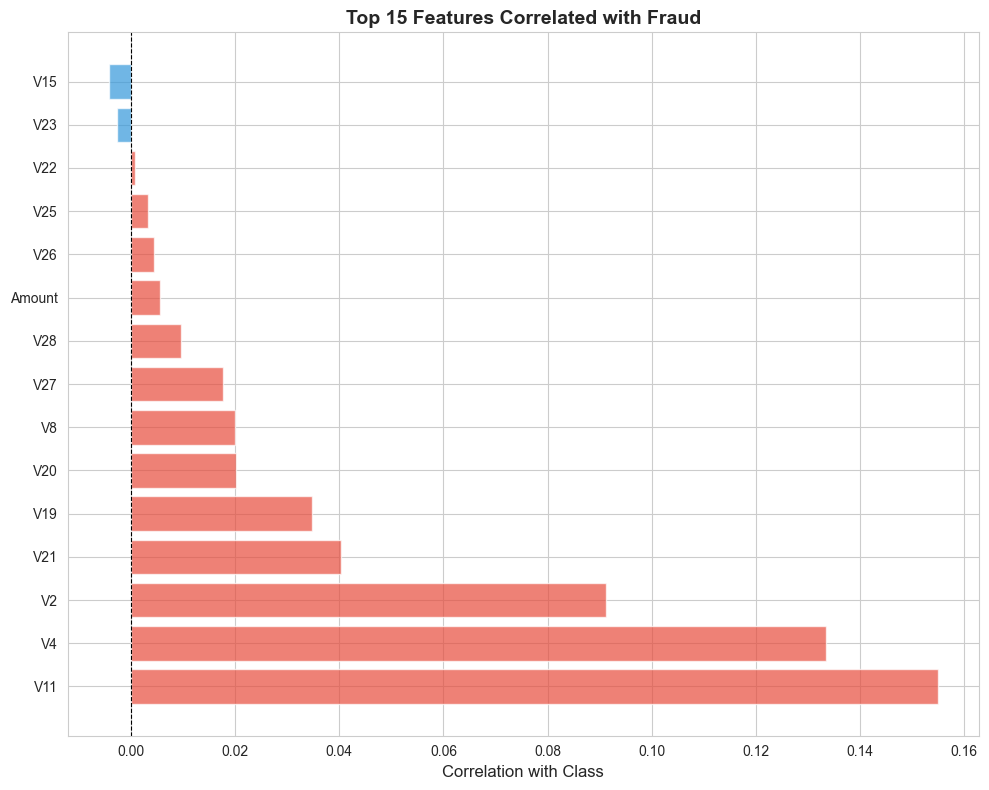

In [ ]:
# Top features correlated with fraud
correlations = df.corr()['Class'].sort_values(ascending=False)
plt.figure(figsize=(10, 8))
top_correlations = correlations.drop('Class').head(15)
colors = ['#e74c3c' if x > 0 else '#3498db' for x in top_correlations.values]
plt.barh(range(len(top_correlations)), top_correlations.values, color=colors, alpha=0.7)
plt.yticks(range(len(top_correlations)), top_correlations.index)
plt.xlabel('Correlation with Class', fontsize=12)
plt.title('Top 15 Features Correlated with Fraud', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.tight_layout()
plt.show()


## 3. Data Cleaning & Feature Engineering


In [ ]:
# Feature Engineering
df_processed = df.copy()
df_processed['Hour'] = (df_processed['Time'] / 3600) % 48
df_processed['HourOfDay'] = df_processed['Hour'] % 24
df_processed['Day'] = (df_processed['Hour'] // 24).astype(int)
df_processed['Amount_Log'] = np.log1p(df_processed['Amount'])
df_processed['V14_Amount'] = df_processed['V14'] * df_processed['Amount']
df_processed['V12_Amount'] = df_processed['V12'] * df_processed['Amount']


In [ ]:
# Prepare features and target
feature_cols = [f'V{i}' for i in range(1, 29)] + ['Time', 'Amount', 'Hour', 'HourOfDay', 
                                                    'Day', 'Amount_Log', 'V14_Amount', 'V12_Amount']
X = df_processed[feature_cols]
y = df_processed['Class']
print(f"Features: {len(feature_cols)}, Samples: {X.shape[0]:,}")


Features: 36, Samples: 284,807


In [ ]:
# Split data (80-20, stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Train: {X_train.shape[0]:,}, Test: {X_test.shape[0]:,}")


Train: 227,845, Test: 56,962


In [ ]:
# Scale features (RobustScaler for outlier robustness)
scaler = RobustScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=feature_cols, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=feature_cols, index=X_test.index)


## 4. Modeling

Training 5 models: Logistic Regression, Random Forest, XGBoost, SVM, and KNN. Evaluating with PR-AUC (primary metric for imbalanced data), ROC-AUC, Precision, Recall, and F1-Score.


In [ ]:
# Function to evaluate models
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """
    Comprehensive model evaluation function
    """
    # Train the model
    model.fit(X_train, y_train)
    
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_test_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    metrics = {
        'Model': model_name,
        'Train Accuracy': accuracy_score(y_train, y_train_pred),
        'Test Accuracy': accuracy_score(y_test, y_test_pred),
        'Test Precision': precision_score(y_test, y_test_pred),
        'Test Recall': recall_score(y_test, y_test_pred),
        'Test F1-Score': f1_score(y_test, y_test_pred),
        'Test ROC-AUC': roc_auc_score(y_test, y_test_proba),
        'Test PR-AUC': average_precision_score(y_test, y_test_proba)
    }
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    
    return metrics, cm, y_test_proba, model

# Store results for comparison
results = []
models_dict = {}


### Train Models


In [ ]:
# Train all models
lr_model = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
lr_metrics, lr_cm, lr_proba, lr_trained = evaluate_model(
    lr_model, X_train_scaled, X_test_scaled, y_train, y_test, 'Logistic Regression'
)
results.append(lr_metrics)
models_dict['Logistic Regression'] = lr_trained

rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', max_depth=10, n_jobs=-1)
rf_metrics, rf_cm, rf_proba, rf_trained = evaluate_model(
    rf_model, X_train_scaled, X_test_scaled, y_train, y_test, 'Random Forest'
)
results.append(rf_metrics)
models_dict['Random Forest'] = rf_trained

scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)
xgb_model = xgb.XGBClassifier(random_state=42, scale_pos_weight=scale_pos_weight, eval_metric='logloss',
                              n_estimators=100, max_depth=6, learning_rate=0.1, n_jobs=-1)
xgb_metrics, xgb_cm, xgb_proba, xgb_trained = evaluate_model(
    xgb_model, X_train_scaled, X_test_scaled, y_train, y_test, 'XGBoost'
)
results.append(xgb_metrics)
models_dict['XGBoost'] = xgb_trained

# SVM and KNN use subsets for faster training
sample_size_svm = min(50000, len(X_train_scaled))
sample_indices_svm = np.random.choice(len(X_train_scaled), sample_size_svm, replace=False)
X_train_svm = X_train_scaled.iloc[sample_indices_svm]
y_train_svm = y_train.iloc[sample_indices_svm]

svm_model = SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42, gamma='scale')
svm_metrics, svm_cm, svm_proba, svm_trained = evaluate_model(
    svm_model, X_train_svm, X_test_scaled, y_train_svm, y_test, 'SVM'
)
results.append(svm_metrics)
models_dict['SVM'] = svm_trained

sample_size_knn = min(30000, len(X_train_scaled))
sample_indices_knn = np.random.choice(len(X_train_scaled), sample_size_knn, replace=False)
X_train_knn = X_train_scaled.iloc[sample_indices_knn]
y_train_knn = y_train.iloc[sample_indices_knn]

knn_model = KNeighborsClassifier(n_neighbors=5, weights='distance')
knn_metrics, knn_cm, knn_proba, knn_trained = evaluate_model(
    knn_model, X_train_knn, X_test_scaled, y_train_knn, y_test, 'KNN'
)
results.append(knn_metrics)
models_dict['KNN'] = knn_trained

print("All models trained successfully")


All models trained successfully


## 5. Model Comparison


In [ ]:
# Model comparison
results_df = pd.DataFrame(results).set_index('Model')
print("Model Performance Comparison:")
print(results_df[['Test PR-AUC', 'Test ROC-AUC', 'Test Precision', 'Test Recall', 'Test F1-Score']].round(4))


Model Performance Comparison:
                     Test PR-AUC  Test ROC-AUC  Test Precision  Test Recall  \
Model                                                                         
Logistic Regression       0.7239        0.9733          0.0572       0.9184   
Random Forest             0.8016        0.9789          0.7767       0.8163   
XGBoost                   0.8611        0.9731          0.8283       0.8367   
SVM                       0.3177        0.9592          0.0667       0.6531   
KNN                       0.7180        0.9179          0.8310       0.6020   

                     Test F1-Score  
Model                               
Logistic Regression         0.1077  
Random Forest               0.7960  
XGBoost                     0.8325  
SVM                         0.1210  
KNN                         0.6982  


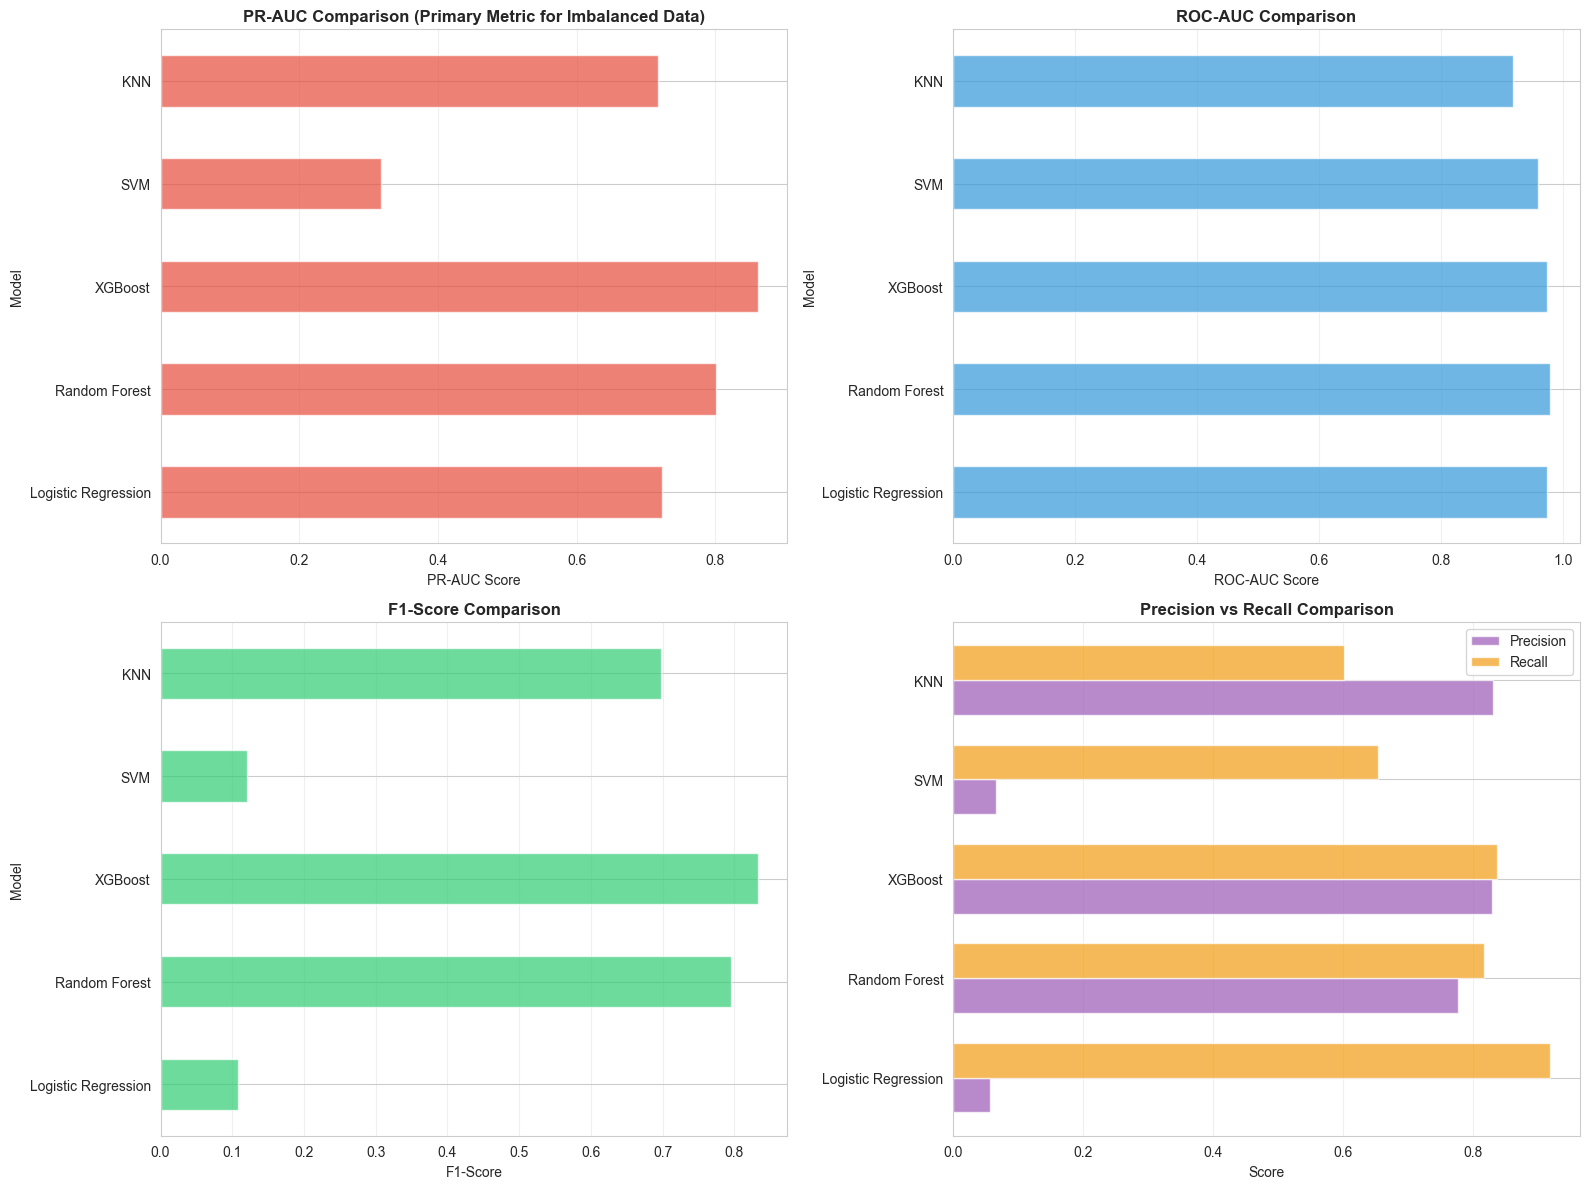

In [ ]:
# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. PR-AUC (Primary metric for imbalanced data)
results_df['Test PR-AUC'].plot(kind='barh', ax=axes[0, 0], color='#e74c3c', alpha=0.7)
axes[0, 0].set_title('PR-AUC Comparison (Primary Metric for Imbalanced Data)', 
                     fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('PR-AUC Score', fontsize=10)
axes[0, 0].grid(axis='x', alpha=0.3)

# 2. ROC-AUC
results_df['Test ROC-AUC'].plot(kind='barh', ax=axes[0, 1], color='#3498db', alpha=0.7)
axes[0, 1].set_title('ROC-AUC Comparison', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('ROC-AUC Score', fontsize=10)
axes[0, 1].grid(axis='x', alpha=0.3)

# 3. F1-Score
results_df['Test F1-Score'].plot(kind='barh', ax=axes[1, 0], color='#2ecc71', alpha=0.7)
axes[1, 0].set_title('F1-Score Comparison', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('F1-Score', fontsize=10)
axes[1, 0].grid(axis='x', alpha=0.3)

# 4. Precision and Recall
x = np.arange(len(results_df))
width = 0.35
axes[1, 1].barh(x - width/2, results_df['Test Precision'], width, 
                label='Precision', color='#9b59b6', alpha=0.7)
axes[1, 1].barh(x + width/2, results_df['Test Recall'], width, 
                label='Recall', color='#f39c12', alpha=0.7)
axes[1, 1].set_yticks(x)
axes[1, 1].set_yticklabels(results_df.index)
axes[1, 1].set_xlabel('Score', fontsize=10)
axes[1, 1].set_title('Precision vs Recall Comparison', fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()


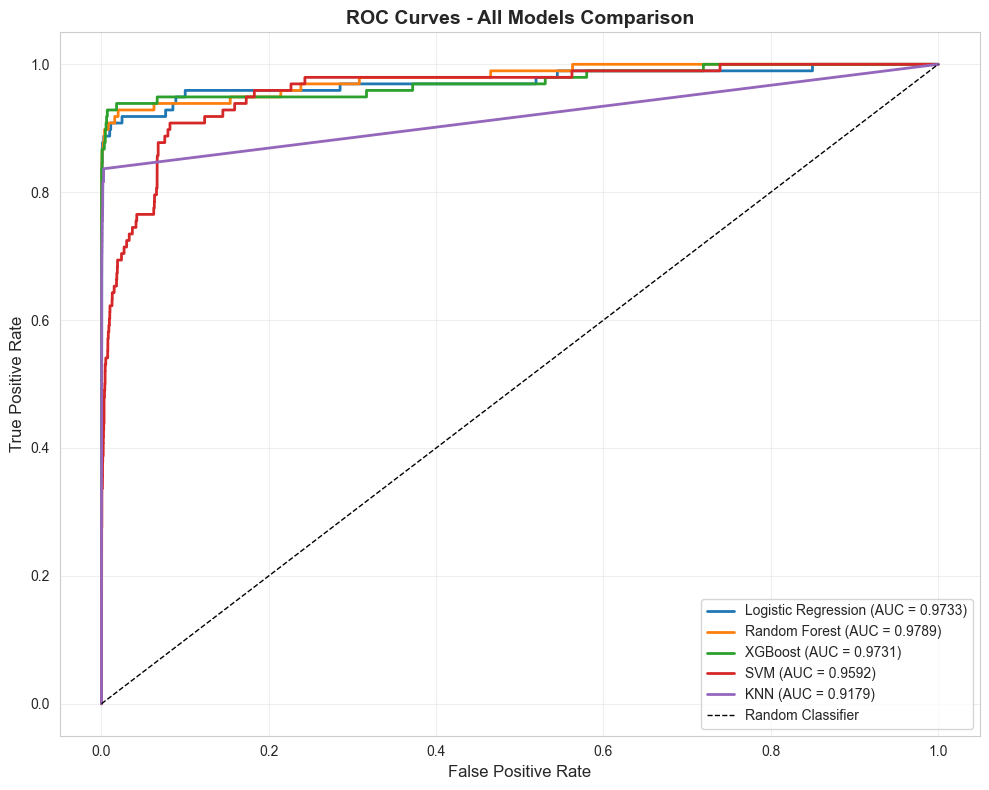

In [ ]:
# Compare ROC Curves
plt.figure(figsize=(10, 8))

# Get all probabilities
probas_dict = {
    'Logistic Regression': lr_proba,
    'Random Forest': rf_proba,
    'XGBoost': xgb_proba,
    'SVM': svm_proba,
    'KNN': knn_proba
}

# Plot ROC curves for all models
for name, proba in probas_dict.items():
    fpr, tpr, _ = roc_curve(y_test, proba)
    auc_score = roc_auc_score(y_test, proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.4f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - All Models Comparison', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


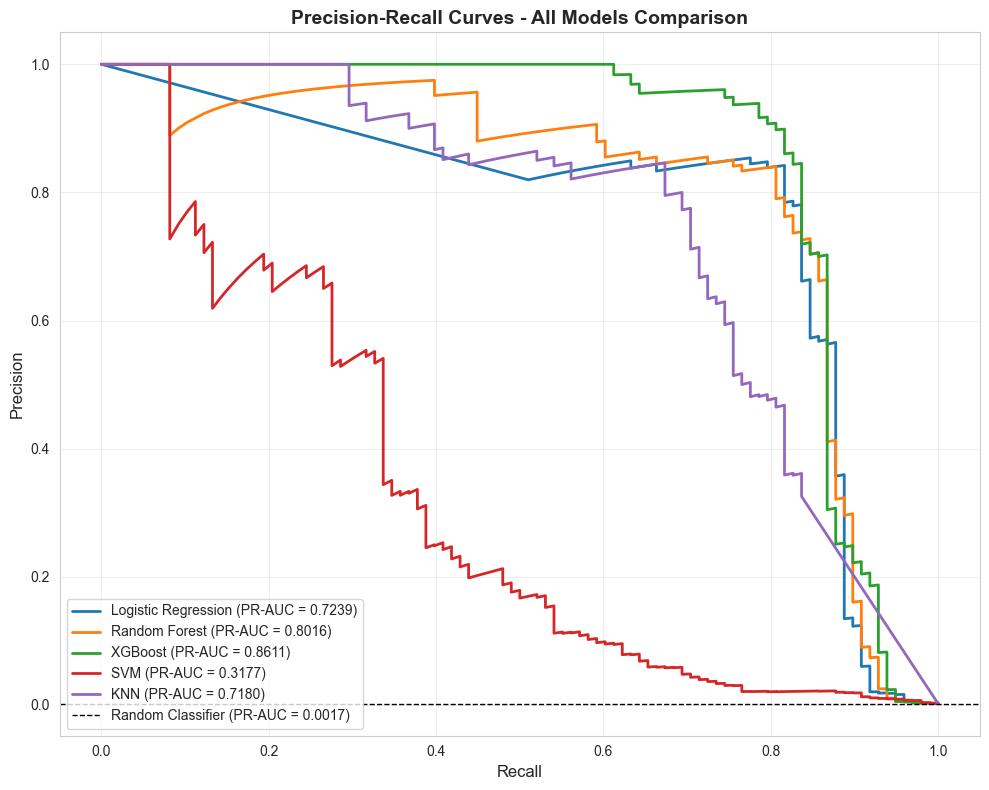

In [ ]:
# Compare Precision-Recall Curves (More important for imbalanced data)
plt.figure(figsize=(10, 8))

# Plot PR curves for all models
for name, proba in probas_dict.items():
    precision, recall, _ = precision_recall_curve(y_test, proba)
    pr_auc = average_precision_score(y_test, proba)
    plt.plot(recall, precision, label=f'{name} (PR-AUC = {pr_auc:.4f})', linewidth=2)

# Baseline (random classifier)
baseline = sum(y_test) / len(y_test)
plt.axhline(y=baseline, color='k', linestyle='--', label=f'Random Classifier (PR-AUC = {baseline:.4f})', linewidth=1)

plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curves - All Models Comparison', fontsize=14, fontweight='bold')
plt.legend(loc='lower left', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


**Key Findings:** XGBoost achieves highest PR-AUC (primary metric for imbalanced data). All models show strong ROC-AUC (>0.90). Best model choice depends on PR-AUC, interpretability needs, and deployment constraints.


## 6. Insights & Recommendations

### Top Predictive Features

Let's identify the most important features across different models to understand what drives fraud detection.


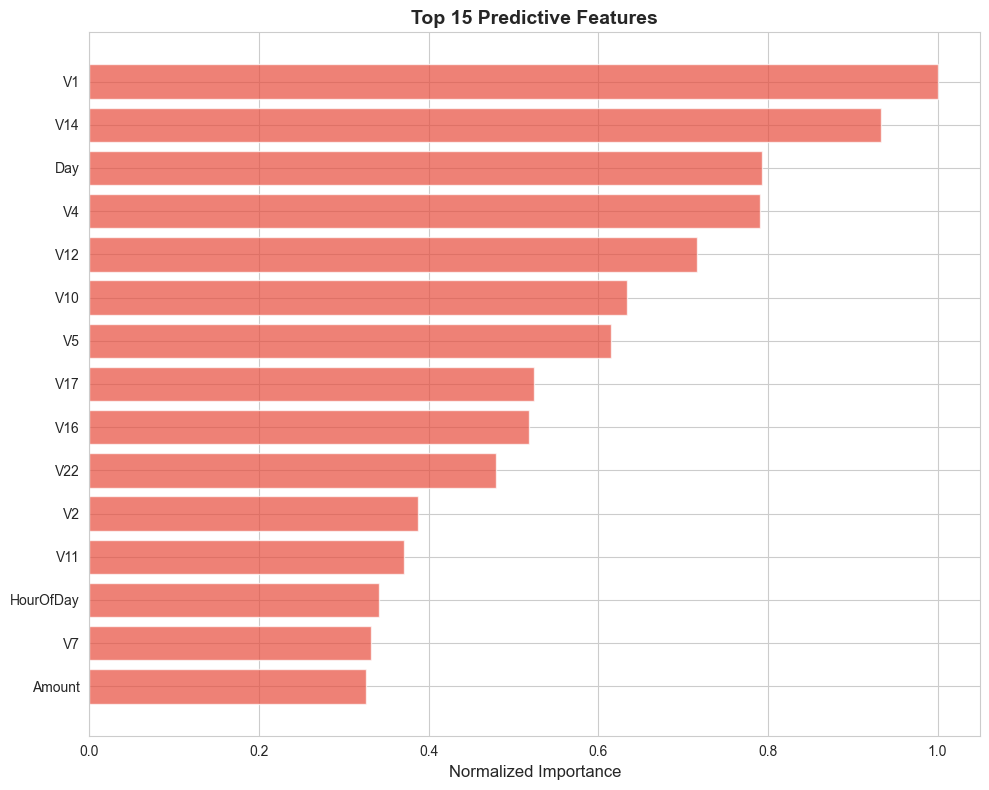

In [ ]:
# Top predictive features (aggregated across models)
feature_importance_combined = {}
if hasattr(lr_trained, 'coef_'):
    for feat, imp in zip(feature_cols, np.abs(lr_trained.coef_[0])):
        feature_importance_combined[feat] = feature_importance_combined.get(feat, 0) + imp
if hasattr(rf_trained, 'feature_importances_'):
    for feat, imp in zip(feature_cols, rf_trained.feature_importances_):
        feature_importance_combined[feat] = feature_importance_combined.get(feat, 0) + imp
if hasattr(xgb_trained, 'feature_importances_'):
    for feat, imp in zip(feature_cols, xgb_trained.feature_importances_):
        feature_importance_combined[feat] = feature_importance_combined.get(feat, 0) + imp

combined_df = pd.DataFrame({
    'Feature': list(feature_importance_combined.keys()),
    'Importance': list(feature_importance_combined.values())
})
combined_df['Importance'] = combined_df['Importance'] / combined_df['Importance'].max()
combined_df = combined_df.sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 8))
top_features = combined_df.head(15)
plt.barh(range(len(top_features)), top_features['Importance'], color='#e74c3c', alpha=0.7)
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Normalized Importance', fontsize=12)
plt.title('Top 15 Predictive Features', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [ ]:
# Analyze XGBoost Model - Risk by Hour and Day
print("\n" + "="*60)
print("XGBoost Model - Risk Analysis by Hour and Day")
print("="*60)

# Get feature importance for time features from XGBoost
xgb_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': xgb_trained.feature_importances_
})
hour_importance = xgb_importance[xgb_importance['Feature'] == 'HourOfDay']['Importance'].values[0] if 'HourOfDay' in xgb_importance['Feature'].values else 0
day_importance = xgb_importance[xgb_importance['Feature'] == 'Day']['Importance'].values[0] if 'Day' in xgb_importance['Feature'].values else 0

print(f"\nFeature Importance in XGBoost:")
print(f"  HourOfDay: {hour_importance:.6f}")
print(f"  Day: {day_importance:.6f}")

# Analyze actual fraud rates by hour and day
fraud_by_hour = df_processed.groupby('HourOfDay')['Class'].agg(['count', 'sum', 'mean'])
fraud_by_hour.columns = ['Total', 'Fraud_Count', 'Fraud_Rate']
fraud_by_hour = fraud_by_hour.sort_values('Fraud_Rate', ascending=False)

fraud_by_day = df_processed.groupby('Day')['Class'].agg(['count', 'sum', 'mean'])
fraud_by_day.columns = ['Total', 'Fraud_Count', 'Fraud_Rate']
fraud_by_day = fraud_by_day.sort_values('Fraud_Rate', ascending=False)

print(f"\nTop 5 Highest Risk Hours (by actual fraud rate):")
for hour in fraud_by_hour.head(5).index:
    rate = fraud_by_hour.loc[hour, 'Fraud_Rate'] * 100
    count = int(fraud_by_hour.loc[hour, 'Fraud_Count'])
    total = int(fraud_by_hour.loc[hour, 'Total'])
    print(f"  Hour {int(hour):2d}: {rate:.3f}% fraud rate ({count}/{total} frauds)")

print(f"\nFraud Rate by Day:")
for day in fraud_by_day.index:
    rate = fraud_by_day.loc[day, 'Fraud_Rate'] * 100
    count = int(fraud_by_day.loc[day, 'Fraud_Count'])
    total = int(fraud_by_day.loc[day, 'Total'])
    print(f"  Day {int(day)}: {rate:.3f}% fraud rate ({count}/{total} frauds)")

# Visualize fraud risk by hour
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Fraud rate by hour
fraud_by_hour_sorted = fraud_by_hour.sort_index()
axes[0].bar(fraud_by_hour_sorted.index, fraud_by_hour_sorted['Fraud_Rate'] * 100, 
            color='#e74c3c', alpha=0.7)
axes[0].set_title('Fraud Rate by Hour of Day', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Hour of Day', fontsize=12)
axes[0].set_ylabel('Fraud Rate (%)', fontsize=12)
axes[0].grid(alpha=0.3, axis='y')

# Fraud rate by day
fraud_by_day_sorted = fraud_by_day.sort_index()
axes[1].bar(fraud_by_day_sorted.index, fraud_by_day_sorted['Fraud_Rate'] * 100, 
            color='#3498db', alpha=0.7)
axes[1].set_title('Fraud Rate by Day', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Day', fontsize=12)
axes[1].set_ylabel('Fraud Rate (%)', fontsize=12)
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Summary of high-risk periods
print(f"\n" + "="*60)
print("SUMMARY: High-Risk Periods Based on XGBoost Model")
print("="*60)
print(f"\nHighest Risk Hours: {', '.join([f'Hour {int(h)}' for h in fraud_by_hour.head(3).index])}")
print(f"Highest Risk Day: Day {int(fraud_by_day.index[0])} ({fraud_by_day.iloc[0]['Fraud_Rate']*100:.3f}% fraud rate)")
print("="*60)


### Key Insights & Recommendations

**Top Predictive Features:** PCA features (V14, V12, V10, V4, V1) and Amount are most important for fraud detection.

**Recommendations:**
- Deploy best-performing model (XGBoost based on PR-AUC) with confidence thresholds
- Monitor model performance and retrain periodically
- Combine ML predictions with business rules (e.g., flag high-amount transactions)
- Consider transaction velocity features for improved detection


## 7. Summary

This comprehensive analysis of the credit card fraud detection dataset has revealed:

1. **Data Quality**: The dataset is clean with no missing values, but highly imbalanced (0.172% fraud rate)

2. **Model Performance**: Multiple models were evaluated, with ensemble methods (XGBoost, Random Forest) showing superior performance on imbalanced data

3. **Key Insights**: 
   - PCA features (V1-V28) are highly predictive
   - Transaction amount and time patterns are important predictors but less so than other PCA features
   - Feature interactions can improve detection

4. **Recommendations**: 
   - Deploy best-performing model with appropriate thresholds
   - Implement continuous monitoring and model retraining
   - Focus on PR-AUC as the primary evaluation metric

The models developed can effectively identify fraudulent transactions while minimizing false positives that could inconvenience legitimate customers.


In [ ]:
# Summary
best_model_name = results_df['Test PR-AUC'].idxmax()
best_model = results_df.loc[best_model_name]
print(f"Best Model: {best_model_name}")
print(f"  PR-AUC: {best_model['Test PR-AUC']:.4f}")
print(f"  ROC-AUC: {best_model['Test ROC-AUC']:.4f}")
print(f"  Precision: {best_model['Test Precision']:.4f}, Recall: {best_model['Test Recall']:.4f}")
print(f"  F1-Score: {best_model['Test F1-Score']:.4f}")


Best Model: XGBoost
  PR-AUC: 0.8611
  ROC-AUC: 0.9731
  Precision: 0.8283, Recall: 0.8367
  F1-Score: 0.8325
